In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import requests
from bs4 import BeautifulSoup
import io

import eurostat

In [3]:
def data_eurostat(code, filter_pars, var_name, pct_change = False):

    data = eurostat.get_data_df(code, filter_pars = filter_pars)

    data = data \
            .filter(regex = '\\d{4}').T \
            .rename(columns = {0: var_name})

    data.index = pd.to_datetime(data.index)

    data = data \
            .to_period('M') \
            .replace('None', np.NaN) \
            .resample('Q') \
            .mean()

    if pct_change == True:
        data = data.pct_change()

    data.dropna(inplace = True)

    return data

## These lines of code are helpful to discover the parameters in a table as well as the values for each parameter in the table
# pars = eurostat.get_pars(code) 
# par_values = eurostat.get_par_values(code, 'geo')

### DATA: CORE HICP [EUROSTAT]

In [4]:
code = 'prc_hicp_midx'
filter_pars = {'unit': 'I15', 'coicop': 'TOT_X_NRG_FOOD', 'geo': 'EA'}

data_hicp = data_eurostat(code, filter_pars, 'core_hicp', pct_change=True)
data_hicp.tail(3)

,core_hicp
2022Q2,0.024363
2022Q3,0.008321
2022Q4,0.015695


### DATA: LONG-TERM INFLATION EXPECTATIONS (SPF - LONG TERM - MEAN) [ECB]

In [5]:
## Source: https://www.pythonsherpa.com/static/files/html/ECB%20-%20Open%20Data.html

# Blocs for the URL
entrypoint = 'https://sdw-wsrest.ecb.europa.eu/service/'
resource = 'data'
flowRef = 'SPF'
key = 'Q.U2.HICP.POINT.LT.Q.AVG'

request_url = entrypoint + resource + '/' + flowRef + '/' + key

response = requests.get(request_url, headers={'Accept': 'text/csv'})

In [6]:
data_lte = pd.read_csv(io.StringIO(response.text))[['TIME_PERIOD', 'OBS_VALUE']] \
            .set_index('TIME_PERIOD') \
            .rename(columns = {'OBS_VALUE': 'spf_long_mean'})

data_lte.index.name = None
data_lte.index = pd.to_datetime(data_lte.index) \
                    .to_period()

data_lte.tail(3)

,spf_long_mean
2022Q2,2.051986
2022Q3,2.152314
2022Q4,2.175381


### DATA: UNEMPLOYMENT RATE [EUROSTAT]

In [7]:
code = 'ei_lmhr_m'
filter_pars = {'s_adj': 'SA', 'indic': 'LM-UN-T-TOT', 'geo': 'EA19'}

data_unemp = data_eurostat(code, filter_pars, 'unemployment')
data_unemp.tail(3)

,unemployment
2022Q2,6.700000
2022Q3,6.633333
2022Q4,6.500000


### DATA: NATURAL RATE OF UNEMPLOYMENT (CALCULATED)

In [8]:
_, data_nairu = sm.tsa.filters.hpfilter(data_unemp, 1600)

data_nairu = data_nairu \
                .to_frame() \
                .rename(columns = {'trend': 'nairu'})

data_nairu.tail(3)

,nairu
2022Q2,6.882222
2022Q3,6.769818
2022Q4,6.657316


### DATA IMPORT PRICES (ALL GOODS, EXTRA-EA COUNTRIES) [EUROSTAT]

In [9]:
code = 'ei_etea19_m'
filter_pars = {'stk_flow': 'IMP', 'unit': 'IVU-NSA', 'indic': 'ET-T', 'geo': 'EA19'}
var_name = 'p_imported'

data_imp = data_eurostat(code, filter_pars, var_name, pct_change=True)
data_imp.tail(3)

,p_imported
2022Q2,0.071992
2022Q3,0.042615
2022Q4,-0.006206


### DATA: OIL PRICES [EIA]

In [10]:
url = 'https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls'

data_oil = pd.read_excel(url, sheet_name='Data 1', header=2, index_col=0)
data_oil.rename(columns={data_oil.columns[0]: 'brent'}, inplace=True)
data_oil = data_oil \
            .resample('Q').mean() \
            .to_period()
data_oil.index.name = ""
data_oil.tail(3)

,brent
,
2022Q3,100.708125
2022Q4,88.723651
2023Q1,79.897273


### DATA: CREDIT SPREADS [BANQUE DE FRANCE]

In [11]:
url_bdf = 'https://publications.banque-france.fr'
url_page = '/en/economic-and-financial-publications-working-papers/credit-risk-euro-area'
page = requests.get(url_bdf + url_page)

soup = BeautifulSoup(page.content, 'html.parser')
url_file = soup.find('div', attrs = {'class': 'bt-consulter clearfix'}).find('a')['href']
url_file = url_bdf + url_file
print(url_file)

https://publications.banque-france.fr/sites/default/files/media/2022/10/07/gm_ea_credit_risk_indicators.xlsx


In [12]:
data_cs = pd.read_excel(url_file, engine='openpyxl', sheet_name='Monthly', index_col=0)[['spr_bk_dom_ea']]
data_cs.index = pd.to_datetime(data_cs.index, format='%Ym%m')
data_cs = data_cs \
            .resample('Q').mean() \
            .to_period() \
            .dropna()
data_cs.tail(3)

,spr_bk_dom_ea
date,
2022Q1,1.042208
2022Q2,1.437589
2022Q3,1.722593


In [13]:
dataset_raw = data_hicp \
            .join(data_lte) \
            .join(data_unemp) \
            .join(data_nairu) \
            .join(data_imp) \
            .join(data_oil) \
            .join(data_cs)
dataset_raw.tail(3)

,core_hicp,spf_long_mean,unemployment,nairu,p_imported,brent,spr_bk_dom_ea
2022Q2,0.024363,2.051986,6.700000,6.882222,0.071992,113.835246,1.437589
2022Q3,0.008321,2.152314,6.633333,6.769818,0.042615,100.708125,1.722593
2022Q4,0.015695,2.175381,6.500000,6.657316,-0.006206,88.723651,NaN


In [18]:
dataset = dataset_raw \
    .assign(
        inf = lambda df_: ((1+df_['core_hicp'])**4 - 1).rolling(4).mean(),
        inf_lag = lambda df_: df_['inf'].shift(4),
        inf_lte = lambda df_: df_['spf_long_mean'].shift(4) / 100,
        labor_mkt_slack = lambda df_: (df_['unemployment'] - df_['nairu']).shift(4),
        rel_imp_price = lambda df_: (((1+df_['p_imported'])**4 - 1) - ((1+df_['core_hicp'])**4 - 1)).shift(4),
        credit_spread = lambda df_: df_['spr_bk_dom_ea'].shift(4)
    )[['inf', 'inf_lag', 'inf_lte', 'labor_mkt_slack', 'rel_imp_price', 'credit_spread']] \
    .dropna()

dataset.tail()

,inf,inf_lag,inf_lte,labor_mkt_slack,rel_imp_price,credit_spread
2021Q4,0.024554,0.003186,0.016562,0.726607,0.060903,1.036198
2022Q1,0.026747,0.012095,0.016891,0.799823,0.203301,0.879832
2022Q2,0.037253,0.009019,0.016842,0.740925,0.121961,0.814534
2022Q3,0.044170,0.014177,0.018160,0.283527,0.254041,0.846666
2022Q4,0.051193,0.024554,0.018986,0.027447,0.282697,0.853931


In [19]:
y = pd.DataFrame(dataset['inf'] - dataset['inf_lag'], columns = ['y']).values.flatten()
X = dataset[['labor_mkt_slack', 'rel_imp_price', 'credit_spread']].copy()
X['inf_lte-inf_lag'] = dataset['inf_lte'] - dataset['inf_lag']
X_names = X.columns
X = X.values

In [20]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

models = {}

for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver='highs')
    model = qr.fit(X, y)
    models[quantile] = model

reg_coef = pd.DataFrame([models[quantile].coef_ for quantile in quantiles], columns=X_names, index=quantiles)

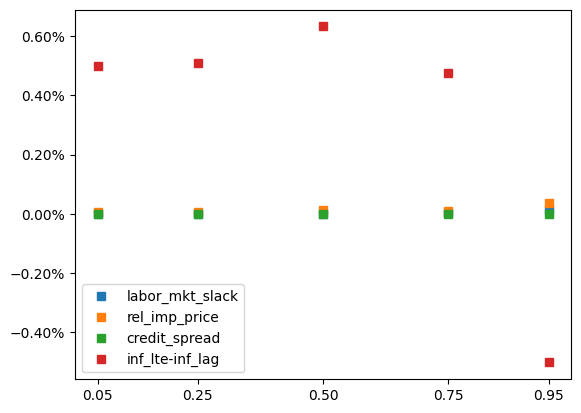

In [21]:
ax = reg_coef.plot(xticks=reg_coef.index, style='s')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))